In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as timess
import math, cmath
import sys
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [2]:
N = 3
spin_ops_list = me.one_body_spin_ops(N)

### Heisenberg Hamiltonian
chain_type = "XXZ"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### Basis operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
identity_op = spin_ops_list[0][0]

label_ops.append("magnetization"); label_ops.append("Neel_op"); 
cl_ops[label_ops[6]] = magnetization; cl_ops[label_ops[7]] = neel_operator; 

print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
cl_ops = me.Hamiltonian_comm_check(H_H, cl_ops, None, True)
cl_ops["identity"] = identity_op

### Initial state

rho_ref = (-.1 * H_H -.9 * (cl_ops["n_oc_op"] - cl_ops["Neel_op"])**2).expm()# .5*(cl_ops["n_oc_op"])**2).expm()
rho_ref = rho_ref/rho_ref.tr()

### Chosen basis and operators 
### ops=[id_glob, n_oc, n_oc**2, x, p , ac, comm, corr, H]

basis = [cl_ops["identity"], cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"], cl_ops["p_op"], 
         cl_ops["p_dot"], cl_ops["comm_xp"], cl_ops["corr_xp"], cl_ops["Neel_op"], H_H]

basis_orth = me.base_orth(basis, rho_ref, me.HS_inner_prod_r, False)

### Evolution 

phi0 = [0., .1, .1, 2., 1., -1., 1, .1, -2., .1]
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()
phi0[0] = -np.log(rho0.tr())
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()
rho0 = rho0/rho0.tr()

Are all the operators Hermitian?: True
[H,  x_op ] = 0?:  False
[H,  p_op ] = 0?:  False
[H,  n_oc_op ] = 0?:  False
[H,  comm_xp ] = 0?:  False
[H,  corr_xp ] = 0?:  False
[H,  p_dot ] = 0?:  False
[H,  magnetization ] = 0?:  True
magnetization basis element deleted
[H,  Neel_op ] = 0?:  False


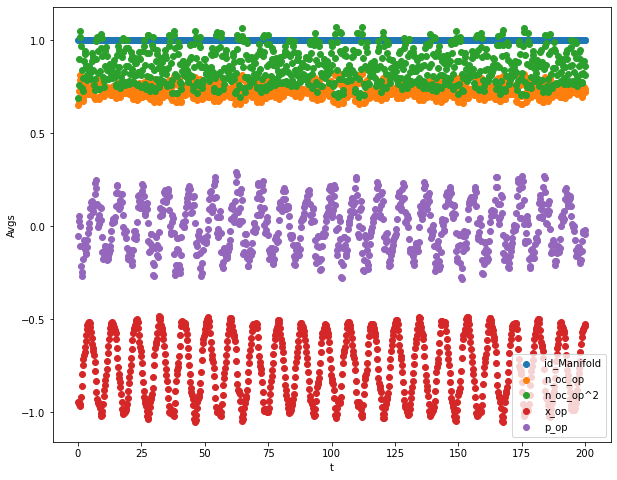

In [3]:
### dinÃ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


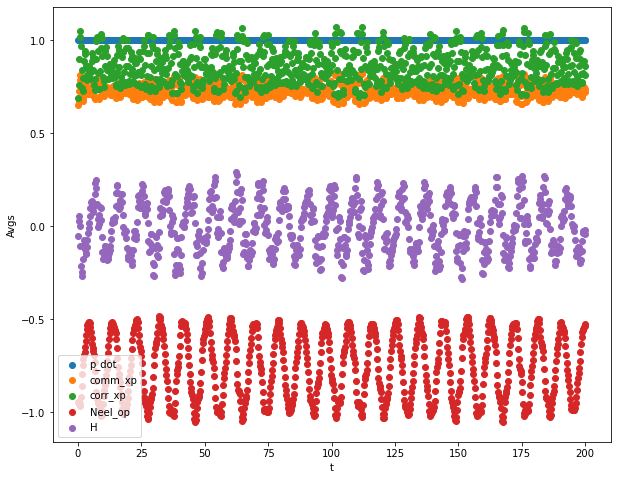

In [4]:
plt.figure(figsize=(10, 8))
for index, name in enumerate(["p_dot", "comm_xp", "corr_xp", "Neel_op", "H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [5]:
Htensor = me.H_ij_matrix(H_H, basis, rho0, me.HS_inner_prod_r)

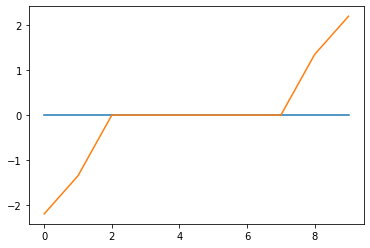

In [6]:
HijT = np.array([[me.HS_inner_prod_r(op2, -1j*(H_H*op1-op1*H_H),rho_ref) for op1 in basis_orth] for op2 in basis_orth])
HijT = (qutip.Qobj(HijT))
plt.plot(qutip.Qobj(HijT).eigenenergies().real)
plt.plot(sorted(qutip.Qobj(HijT).eigenenergies().imag))

In [7]:
ts1 = np.linspace(0, 200, 500)

Phi_vector_solution = []
Phi_vector_solution.append(np.array(phi0))

for i in range(len(ts1)-1):
    a = ( ts1[i+1] * HijT ).expm() * Phi_vector_solution[i]
    Phi_vector_solution.append(a)
    
rho_at_timet = []
rho_at_timet.append(rho0)

for i in range(len(Phi_vector_solution)):
    rhot= (-sum( f*op for f,op in zip(Phi_vector_solution[i], basis_orth))).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet.append(rhot)

for t in range(len(rho_at_timet)):
    if not me.is_density_op(rho_at_timet[t]):
        print("At time", t, "not density op")

At time 30 not density op
At time 33 not density op
At time 41 not density op
At time 115 not density op
At time 121 not density op
At time 133 not density op
At time 180 not density op
At time 231 not density op
At time 237 not density op
At time 286 not density op
At time 294 not density op
At time 296 not density op
At time 304 not density op
At time 318 not density op
At time 331 not density op
At time 343 not density op
At time 413 not density op
At time 415 not density op
At time 431 not density op
At time 461 not density op
At time 471 not density op
At time 487 not density op


C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


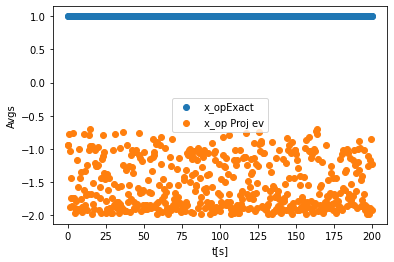

In [8]:
for index, name in enumerate(["x_op"]): #(["n_oc_op", "x_op", "p_op"])
    plt.scatter(res.times, res.expect[index], label = name + "Exact")
    
#plt.scatter(ts1, (qutip.expect(cl_ops["n_oc_op"], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")
plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet)[:-1]), label = "x_op Proj ev")
#plt.scatter(ts1, (qutip.expect(cl_ops["p_op"], rho_at_timet)[:-1]), label = "p_op Proj ev")

plt.xlabel("t[s]")
plt.ylabel("Avgs")
plt.legend()

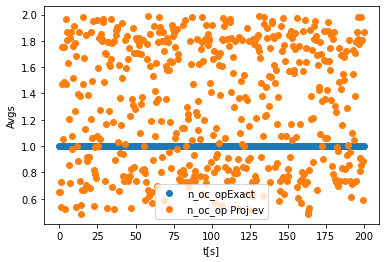

In [9]:
for index, name in enumerate(["n_oc_op"]):#, "x_op", "p_op"]):
    plt.scatter(res.times, res.expect[index], label = name + "Exact")
    
plt.scatter(ts1, (qutip.expect(cl_ops["n_oc_op"], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")

plt.xlabel("t[s]")
plt.ylabel("Avgs")
plt.legend()